# Lab 3 - Machine Learning

| Authors |
|---------|
| Austin Milne |
| Jude Bennett |
| William Ancich |

## IR Distance Sensor Profiling
Four sensors were used. Two short range sensors (4cm-30cm) and two long range sensors (20cm-150cm). Each pair of sensors (short + short & long + long) were measured at 6 distances that are relevant to their range. Based on Lab 1, the sensor are profiled against the function:

$$
D = \frac{a}{V} + b \\~\\
\begin{aligned}
    D & = \text{Distance} \\
    V & = \text{Voltage} \\
    a, \, b & = \text{Constants} \\
\end{aligned}
$$

In [2]:
# Necessary Libraries
import json
import copy
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mergedeep import merge
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.spatial.distance import cdist
from sklearn.metrics import r2_score
import pathlib
import statistics

# Read Raw Data
with open(r"data/data.json") as f:
    data = json.load(f)

C:\Users\austi\AppData\Local\Temp\ipykernel_29512\623431426.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Check Voltages
Plot the voltages to visually inspect that the sensors are behaving as expected.

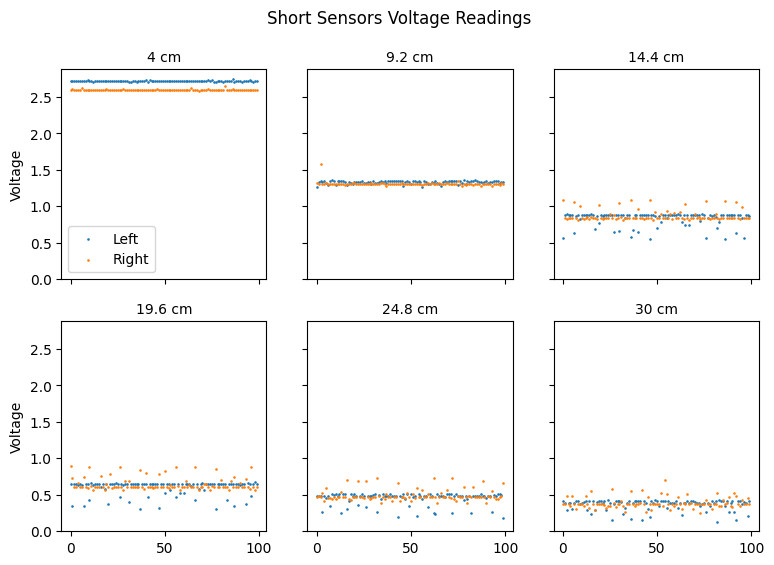

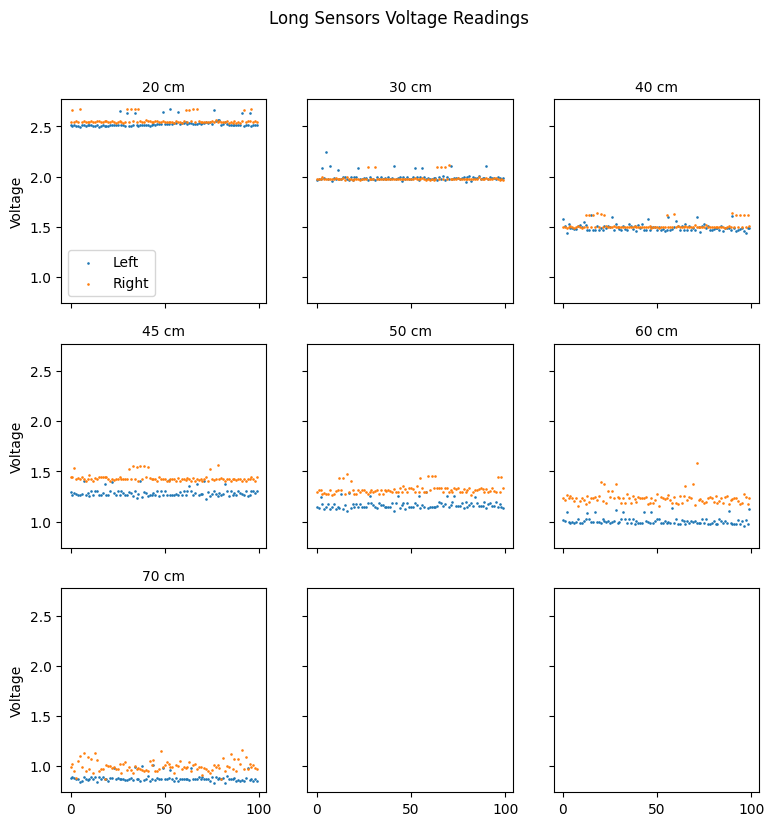

In [3]:
# Plot the voltage readings for each distance
def plot_voltages(data, name):
    distances = list(data.keys())
    distances.sort(key=lambda x: float(x))
    count=len(distances)
    columns = 3
    rows = math.ceil((count - count%3)/3)
    rows = rows+1 if count%3 else rows
    fig, axs = plt.subplots(rows, columns, sharex=True, sharey=True, figsize=(3*columns, 3*rows))
    fig.suptitle(f'{name} Voltage Readings')
    for i, distance in enumerate(distances):
        # Create dataframe with each sensor's data
        df = pd.DataFrame({
            "Time": np.arange(start=0, stop=len(data[distance]["data"][0])*(1/20), step=(1/20)),
            "Left": data[distance]["data"][0],
            "Right": data[distance]["data"][1]
        })
        # Plot each sensor's data
        # sub = axs[(i-(i%3))/3, i%3]
        sub = axs[int((i-(i%3))/3), i%3]
        for sensor in ["Left", "Right"]:
            sub.scatter(df.index, df[sensor], label=sensor, s=0.75)
        sub.set_title(f"{distance} cm", fontsize=10)
        if (i%3 == 0): sub.set_ylabel("Voltage")
        if (i==0): sub.legend()
    plt.show()
    fig.savefig(f"out/plots/{name} Voltage Readings.png")

# Plot voltages for short and long sensors
dcs = data["Calibrations"]["Short"]
dcl = data["Calibrations"]["Long"]

plot_voltages(dcs, "Short Sensors")
plot_voltages(dcl, "Long Sensors")

## IR Sensor Calibration
Determine the relevant constants for each sensor to fit the inverse relationship between voltage and distance.

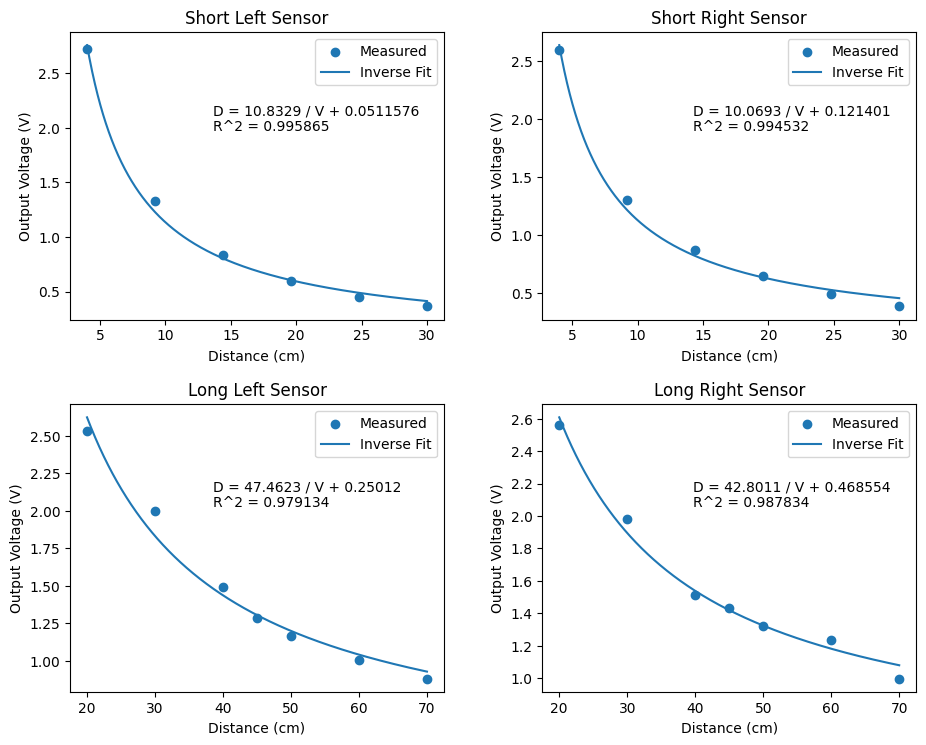

Sensor Properties
     Sensor                    Function      R^2
 Short Left D = 10.8329 / V + 0.0511576 0.995865
Short Right  D = 10.0693 / V + 0.121401 0.994532
  Long Left   D = 47.4623 / V + 0.25012 0.979134
 Long Right  D = 42.8011 / V + 0.468554 0.987834


In [4]:
# Run regression on range of functions for each sensor
sensors = ["Left", "Right"]
sets = ["Short", "Long"]
dc = data["Calibrations"]
sensor_params = {}
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.tight_layout(pad=4.0)
for i, set in enumerate(sets):
    for j, tc_id in enumerate(sensors):
        readings = pd.DataFrame({
            "Distance": [float(dist) for dist in dc[set].keys()],
            "Voltage": [np.mean(dc[set][dist]["data"][j]) for dist in dc[set]]
        })
        readings.sort_values(by="Distance", inplace=True)
        readings.reset_index(drop=True, inplace=True)
        
        # Inverse Regression
        inverse = lambda x, a, b : a/x + b
        inv_a, inv_b = curve_fit(inverse, readings["Distance"], readings["Voltage"])[0]
        inv_r2 = r2_score(readings["Voltage"], inverse(np.asarray(readings["Distance"]), inv_a, inv_b))
        merge(sensor_params, {
            set: {
                tc_id: {
                    "a": inv_a,
                    "b": inv_b,
                    "r2": inv_r2,                    
                }
            }
        })
                
        # Plot the sensor data and regressions lines
        pts = np.linspace(min(readings["Distance"]), max(readings["Distance"]), 1000)
        sub = axs[i, j]
        sub.scatter(readings["Distance"], readings["Voltage"], label="Measured")
        sub.plot(pts, inverse(np.asarray(pts), inv_a, inv_b), label=f"Inverse Fit")
        sub.set_title(f"{set} {tc_id} Sensor")
        sub.set_xlabel("Distance (cm)")
        sub.set_ylabel("Output Voltage (V)")
        sub.text(0.23 + j*0.48, 0.8 - i*0.47, f"D = {inv_a:3.6} / V + {inv_b:3.6}\nR^2 = {inv_r2:3.6}", fontsize=10, transform=plt.gcf().transFigure)
        sub.legend()
    
pathlib.Path("out/plots").mkdir(parents=True, exist_ok=True)
plt.savefig(f"out/plots/IR Sensor Fits.png")
plt.show()

# Print Sensor Properties Formula in pretty table
print("Sensor Properties")
functions = []
for set in sensor_params:
    for tc_id in sensor_params[set]:
        functions.append({
            "Sensor": f"{set} {tc_id}",
            "Function": f"D = {sensor_params[set][tc_id]['a']:3.6} / V + {sensor_params[set][tc_id]['b']:3.6}",
            "R^2": sensor_params[set][tc_id]['r2']
        })
functions = pd.DataFrame(functions)
print(functions.to_string(index=False))



## Thermocouple Calibration and Profiling
Four thermocouples were used. All the thermocouples were measured with the heater in 9 different positions.

### Data Parsing and Organization
Read in and clean up the data for the thermocouples.

NameError: name 'tc_pts' is not defined

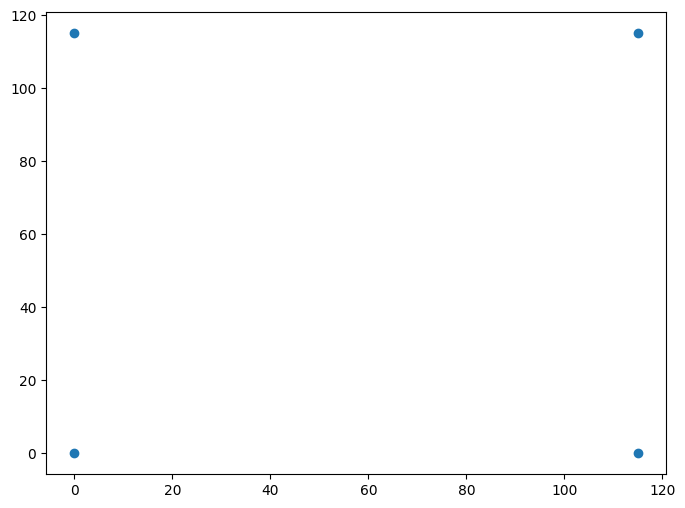

In [5]:
# Hardcode measured distances for reference points
CUBE_L = 30 # Length/Width of the usable area
displacement_to_square_center = np.array([CUBE_L/2, CUBE_L/2])

# As measured from the axes (edge of box) to the closest face of block
training_pts = np.array([
    (74, 6),
    (39, 12),
    (12, 5),
    (71, 38),
    (40, 40),
    (10, 38),
    (72, 73),
    (40, 75),
    (8, 75)
])
# Test Points
test_pts = np.array([
    (55, 24),
    (19, 40),
    (55, 70)
])

# Visualize the training and test points
center_training_pts = training_pts + displacement_to_square_center
plate_corners = np.array([
    (0,0),
    (0,115),
    (115, 0),
    (115,115)
])

# Create scatter plots
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.scatter(plate_corners[:,0],       plate_corners[:,1],       label='Plate Corners')
plt.scatter(tc_pts[:,0],              tc_pts[:,1],              label='Thermocouple Locations')
plt.scatter(center_training_pts[:,0], center_training_pts[:,1], label='Training Points')
plt.scatter(test_pts[:,0],            test_pts[:,1],            label='Test Points')
plt.xlabel('X-axis (mm)')
plt.ylabel('Y-axis (mm)')
plt.title('Experimental Setup Layout')
plt.legend()

# Show plot
plt.grid(True)
plt.savefig("out/plots/Experimental Setup Layout.png")
plt.show()

In [ ]:

# Channels 0-3
tc_training_dist = cdist(training_pts + displacement_to_square_center, tc_pts)
tc_test_dist = cdist(test_pts + displacement_to_square_center, tc_pts)

# Channels 4,5
ir_y_training_dist = np.stack((training_pts[:, 1] + 50 - 1/2*CUBE_L, ) * 2, axis=1)
ir_y_test_dist = np.stack((test_pts[:, 1] + 50 - 1/2*CUBE_L, ) * 2, axis=1)

# Channels 6,7
ir_x_training_dist = np.stack((training_pts[:, 0] + 300 - 1/2*CUBE_L, ) * 2, axis=1)
ir_x_test_dist = np.stack((test_pts[:, 0] + 300 - 1/2*CUBE_L, ) * 2, axis=1)

# Combine all distances
training_dist = np.concatenate([tc_training_dist, ir_y_training_dist, ir_x_training_dist], axis=1)
test_dist = np.concatenate([tc_test_dist, ir_y_test_dist, ir_x_test_dist], axis=1)

# Labels for the data
training_labels = [f'P{i+1}' for i in range(training_dist.shape[0])]
test_labels = [f'A{i+1}' for i in range(test_dist.shape[0])]

# Create training labels
training_labels = [f'P{i+1}' for i in range(training_dist.shape[1])]

# Get the mean temperatures for each thermo couple
training_mean_voltages = copy.deepcopy(data["TrainingData"])
for i, pt_key in enumerate(data["TrainingData"].keys()):
    # Shape is (num_channels, num_readings) or (8, 100)
    channel_readings = np.array(data["TrainingData"][pt_key]["data"])
    channel_mean_voltages = np.mean(channel_readings, axis=1)
    # We're overwriting the "time" and "data" fields with
    # a single array that contains the mean voltage readings for each channel
    training_mean_voltages[pt_key] = channel_mean_voltages

# Create a dataframe for the mean voltages
tr_mv_df = pd.DataFrame(training_mean_voltages)
tr_mv_df.index.name = "channel"
tr_mv_df.columns.name = "set"
tr_mv_df.drop(columns="control", inplace=True) # Ignore the control measurment

# Convert the mean voltages to temperatures
def voltage_to_temperature(V_out):
    return (V_out-1.25)/0.005
tr_tc_mv_df = tr_mv_df.loc[0:3, :]
tr_tc_T_df = voltage_to_temperature(tr_tc_mv_df).T

# Training distances dataframe
tr_tc_d_df = pd.DataFrame(tc_training_dist, index=tr_tc_T_df.index, columns=tr_tc_T_df.columns)


### Check Voltages
Plot the voltages to visually inspect that the sensors are behaving as expected.

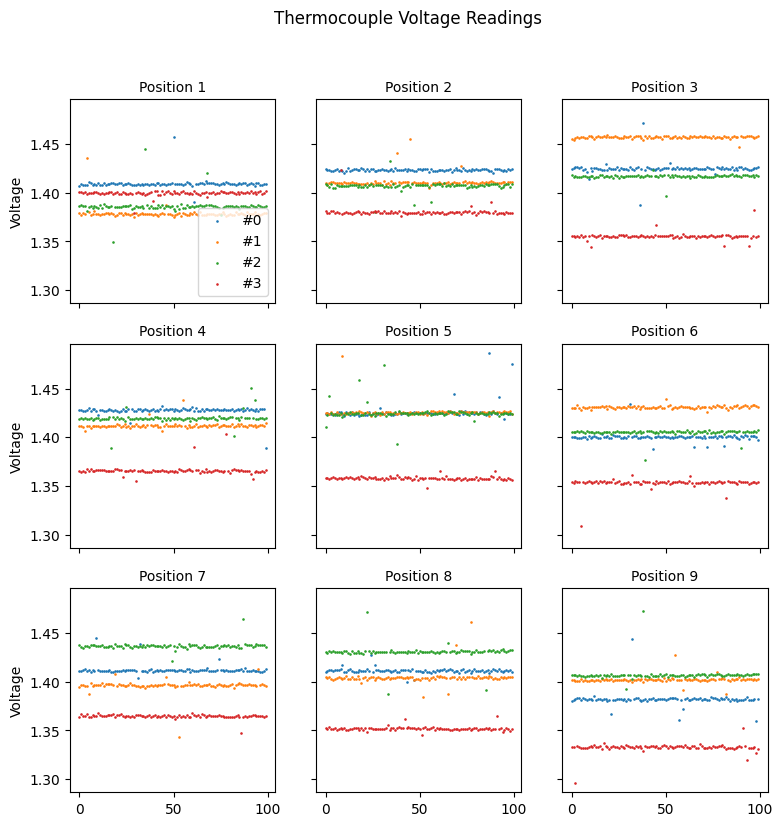

In [ ]:
# Plot the voltage readings of the thermocouples for each position: 1-9
tc_data = data["TrainingData"]
distances = list(tc_data.keys())
distances.sort(key=lambda x: x)
distances.remove("control")
count=len(distances)
columns = 3
rows = math.ceil((count - count%3)/3)
rows = rows+1 if count%3 else rows
fig, axs = plt.subplots(rows, columns, sharex=True, sharey=True, figsize=(3*columns, 3*rows))
fig.suptitle(f'Thermocouple Voltage Readings')
for i, distance in enumerate(distances):
    # Create dataframe with each sensor's data
    df = pd.DataFrame({
        "Time": np.arange(start=0, stop=len(tc_data[distance]["data"][0])*(1/20), step=(1/20)),
        "0": tc_data[distance]["data"][0],
        "1": tc_data[distance]["data"][1],
        "2": tc_data[distance]["data"][2],
        "3": tc_data[distance]["data"][3],
    })
    # Plot each sensor's data
    # sub = axs[(i-(i%3))/3, i%3]
    sub = axs[int((i-(i%3))/3), i%3]
    for sensor in ["0", "1", "2", "3"]:
        sub.scatter(df.index, df[sensor], label=f'#{sensor}', s=0.75)
    sub.set_title(f"Position {distance[1]}", fontsize=10)
    if (i%3 == 0): sub.set_ylabel("Voltage")
    if (i==0): sub.legend()
fig.savefig(f"out/plots/Thermocouple Voltage Readings.png")
plt.show()

### Compare Regressions
Run a series of different regressions to better understand how the sensor behave.

NameError: name 'tr_tc_T_df' is not defined

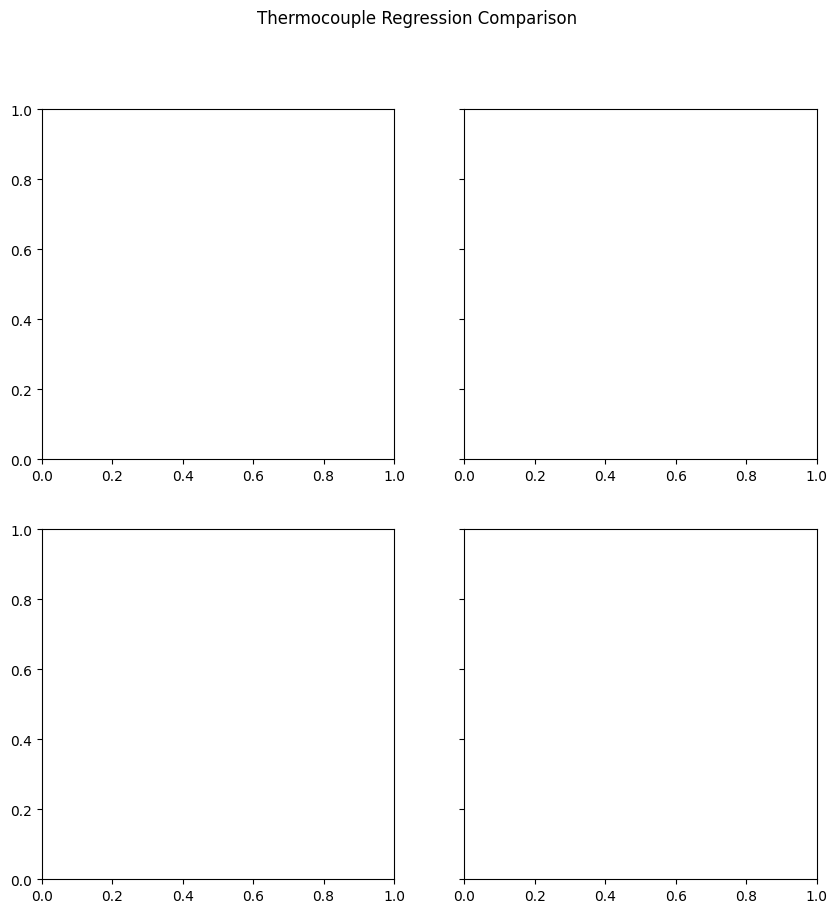

In [6]:
sensor = dict()
fig, axs = plt.subplots(2, 2, sharex=False, sharey=True, figsize=(5*2, 5*2))
fig.suptitle(f'Thermocouple Regression Comparison')
for i, tc_id in enumerate(tr_tc_T_df.columns):
    temperatures = tr_tc_T_df[tc_id]
    distances = tr_tc_d_df[tc_id]

    x = temperatures
    y = distances

    sensor[tc_id] = dict()

    # Linear Regression
    linear = lambda x, m, b : m*x + b # Lambda for linear regression
    lin_m, lin_b = curve_fit(linear, x, y)[0] # Fit the data to the linear model
    lin_r2 = r2_score(y, linear(np.asarray(x), lin_m, lin_b)) # Get the R^2 value
    sensor[tc_id]["linear"] = [lin_m, lin_b, lin_r2] # Store the linear regression results
    
    # Inverse Regression
    inverse = lambda x, a, b : a/x + b # Lambda for inverse regression
    inv_a, inv_b = curve_fit(inverse, x, y)[0] # Fit the data to the inverse model
    inv_r2 = r2_score(y, inverse(np.asarray(x), inv_a, inv_b)) # Get the R^2 value
    sensor[tc_id]["inverse"] = [inv_a, inv_b, inv_r2] # Store the inverse regression results
    
    # Quadratic Regression
    quadratic = lambda x, a, b, c : a*x**2 + b*x + c # Lambda for quadratic regression
    quad_a, quad_b, quad_c = curve_fit(quadratic, x, y)[0] # Fit the data to the quadratic model
    quad_r2 = r2_score(y, quadratic(np.asarray(x), quad_a, quad_b, quad_c)) # Get the R^2 value
    sensor[tc_id]["quadratic"] = [quad_a, quad_b, quad_c, quad_r2] # Store the quadratic regression results
    
    # Inverse Square Regression
    inverse_s = lambda x, a, b, c : a/x**2 + b*x + c # Lambda for quadratic regression
    invs_a, invs_b, invs_c = curve_fit(inverse_s, x, y)[0] # Fit the data to the quadratic model
    invs_r2 = r2_score(y, inverse_s(np.asarray(x), invs_a, invs_b, invs_c)) # Get the R^2 value
    sensor[tc_id]["inverse_s"] = [invs_a, invs_b, invs_c, invs_r2] # Store the quadratic regression results
    
    # Cubic Regression
    cubic = lambda x, a, b, c, d : a*x**3 + b*x**2 + c*x + d # Lambda for cubic regression
    cub_a, cub_b, cub_c, cub_d = curve_fit(cubic, x, y)[0] # Fit the data to the cubic model
    cub_r2 = r2_score(y, cubic(np.asarray(x), cub_a, cub_b, cub_c, cub_d)) # Get the R^2 value
    sensor[tc_id]["cubic"] = [cub_a, cub_b, cub_c, cub_d, cub_r2] # Store the cubic regression results

    # Create a plot of the sensor data and regressions lines
    pts = np.linspace(min(x), max(x), 1000)
    row = int(i%2)
    column = int((i-(i%2))/2)
    sub = axs[column, row]
    sub.scatter(x, y, label="Measured")
    sub.plot(pts, linear(np.asarray(pts), lin_m, lin_b), label=f"Linear")
    sub.plot(pts, inverse(np.asarray(pts), inv_a, inv_b), label=f"Inverse")
    sub.plot(pts, quadratic(np.asarray(pts), quad_a, quad_b, quad_c), label=f"Quadratic")
    sub.plot(pts, inverse_s(np.asarray(pts), invs_a, invs_b, invs_c), label=f"Inverse Square")
    sub.plot(pts, cubic(np.asarray(pts), cub_a, cub_b, cub_c, cub_d), label=f"Cubic")
    sub.set_title(f"Thermocouple #{tc_id+1}")
    sub.set_xlabel("Temperature (deg C)")
    sub.set_ylabel("Output Distance (mm)")
    if(i == 3): sub.legend()
    
    # Create a table of the regression results
    results = pd.DataFrame({
        "Model": ["Linear", "Inverse", "Quadratic", "Inverse Sq." "Cubic"],
        "R^2": [lin_r2, inv_r2, quad_r2, cub_r2],
        "Parameters": [
            f"y = {lin_m:3.8}x + {lin_b:3.8}",
            f"y = {inv_a:3.8}/x + {inv_b:3.8}",
            f"y = {quad_a:3.8}x^2 + {quad_b:3.8}x + {quad_c:3.8}",
            f"y = {invs_a:3.8}/x^2 + {invs_b:3.8}x + {invs_c:3.8}",
            f"y = {cub_a:3.8}x^3 + {cub_b:3.8}x^2 + {cub_c:3.8}x + {cub_d:3.8}"
        ]
    })
    pd.set_option('display.width', 1000)
    print(f"{tc_id} Sensor Regression Results")
    print(results.to_string(index=False))

# Save the regression results to a file
pathlib.Path("out/plots").mkdir(parents=True, exist_ok=True)
plt.savefig(f"out/plots/Thermocouple Regressions.png")
plt.show()

### Linear Regression
Run detailed Linear Regression to determine the constants for the thermocouples.

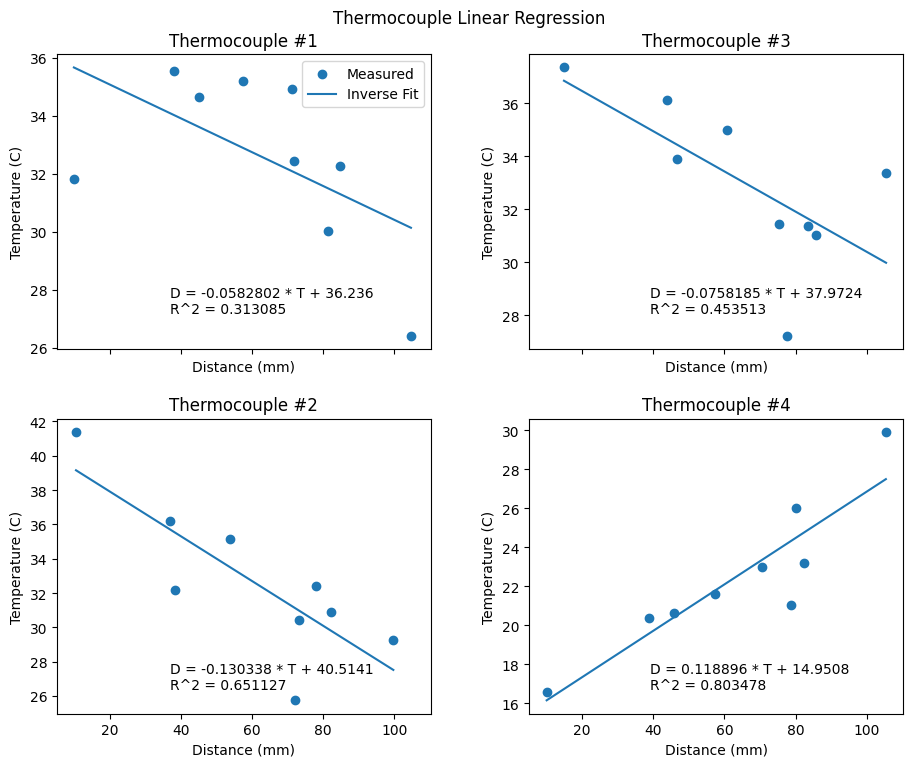

Sensor Properties
Sensor                     Function      R^2
Long 0  D = -0.0582802 * T + 36.236 0.313085
Long 1  D = -0.130338 * T + 40.5141 0.651127
Long 2 D = -0.0758185 * T + 37.9724 0.453513
Long 3   D = 0.118896 * T + 14.9508 0.803478


In [ ]:
# Run regression on range of functions for each sensor
sensors = []
sensor_params = {}
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(10, 8))
fig.tight_layout(pad=4.0)
fig.suptitle(f'Thermocouple Linear Regression')
for i, tc_id in enumerate(tr_tc_T_df.columns):
    readings = pd.DataFrame({
        "Distance": tr_tc_d_df[tc_id],
        "Temp": tr_tc_T_df[tc_id],
    })
    readings.sort_values(by="Distance", inplace=True)
    readings.reset_index(drop=True, inplace=True)
    
    # Inverse Regression
    inverse = lambda x, a, b : a*x + b
    inv_a, inv_b = curve_fit(inverse, readings["Distance"], readings["Temp"])[0]
    inv_r2 = r2_score(readings["Temp"], inverse(np.asarray(readings["Distance"]), inv_a, inv_b))
    merge(sensor_params, {
        set: {
            tc_id: {
                "a": inv_a,
                "b": inv_b,
                "r2": inv_r2,                    
            }
        }
    })
            
    # Plot the sensor data and regressions lines
    pts = np.linspace(min(readings["Distance"]), max(readings["Distance"]), 1000)
    column = int(i%2)
    row = int((i-(i%2))/2)
    sub = axs[column, row]
    sub.scatter(readings["Distance"], readings["Temp"], label="Measured")
    sub.plot(pts, inverse(np.asarray(pts), inv_a, inv_b), label=f"Inverse Fit")
    sub.set_title(f"Thermocouple #{tc_id+1}")
    sub.set_xlabel("Distance (mm)")
    sub.set_ylabel("Temperature (C)")
    sub.text(0.2 + row*0.48, 0.6 - column*0.47, f"D = {inv_a:3.6} * T + {inv_b:3.6}\nR^2 = {inv_r2:3.6}", fontsize=10, transform=plt.gcf().transFigure)
    if (i==0): sub.legend()

# Save and show the plot
pathlib.Path("out/plots").mkdir(parents=True, exist_ok=True)
plt.savefig(f"out/plots/Thermocouple Sensor Fits.png")
plt.show()

# Print Sensor Properties Formula in pretty table
print("Sensor Properties")
functions = []
for set in sensor_params:
    for tc_id in sensor_params[set]:
        functions.append({
            "Sensor": f"{set} {tc_id}",
            "Function": f"D = {sensor_params[set][tc_id]['a']:3.6} * T + {sensor_params[set][tc_id]['b']:3.6}",
            "R^2": sensor_params[set][tc_id]['r2']
        })
functions = pd.DataFrame(functions)
print(functions.to_string(index=False))

